### Install libraries

In [1]:
%tensorflow_version 2.x

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [3]:
!pip install boto3 botocore opencv-python matplotlib seaborn split-folders

     |████████████████████████████████| 132 kB 5.3 MB/s 
     |████████████████████████████████| 8.7 MB 37.8 MB/s 
     |████████████████████████████████| 79 kB 8.2 MB/s 
     |████████████████████████████████| 138 kB 86.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


### Import libraries

In [4]:
import os
import json
import os.path as osp
import boto3
import botocore
import cv2
import yaml
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Define environmet variables and constants

In [5]:
with open("config.yaml", "r") as stream:
    try:
        config = yaml.safe_load(stream)        
    except yaml.YAMLError as e:
        print(e)

# Define width and length of images
img_w = img_h = 300
image_path = "images/"
min_img_per_class = 50

### Remove previous files

In [6]:
! rm -rf images

### Copy images from S3

In [7]:
s3 = boto3.resource("s3", 
                    aws_access_key_id = config["S3"]["AWS_ACCESS_KEY_ID"],
                    aws_secret_access_key = config["S3"]["AWS_SECRET_ACCESS_KEY"]
                    )
bucket = s3.Bucket(config["S3"]["BUCKET"])

for bucket_object in bucket.objects.all():
    try:
        filename = bucket_object.key.strip()
        if filename.startswith(image_path) and not(filename.endswith(".json")):
            if len(filename.split('/')) == 3:
                _, gemstone, name = filename.split('/')
                # Check if is a file
                if name != '':
                    path = "/".join(filename.split("/")[0:2])
                    os.makedirs(path, exist_ok=True)
                    bucket.download_file(filename, filename)
    except Exception as e:
        print("Can't download file: " + filename)
        print(e)

### Load and prepare images

In [8]:
def load_images(path: str):
    images, labels = [], []

    # Navigate from data directory
    for root, dirs, files in os.walk(path):
        gemstone_name = osp.basename(root)
        if len(files) >= 1:
            for file in files:
                labels.append(gemstone_name)
                try:
                    # Read image with cv
                    image = cv2.imread(root + '/' + file)
                    # Resize images
                    image = cv2.resize(image, (img_w , img_h))
                    # Convert image from default BGR to RGB
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    images.append(image)
                except Exception as e:
                    print("Failes to process image with error: " + str(file))
    return (np.array(images), np.array(labels))


In [9]:
images, labels = load_images(image_path)
print("{0} gemstone with {1} images".format(len(np.unique(labels)), len(images)))

80 gemstone with 3304 images


### Distribution of images by gemstone

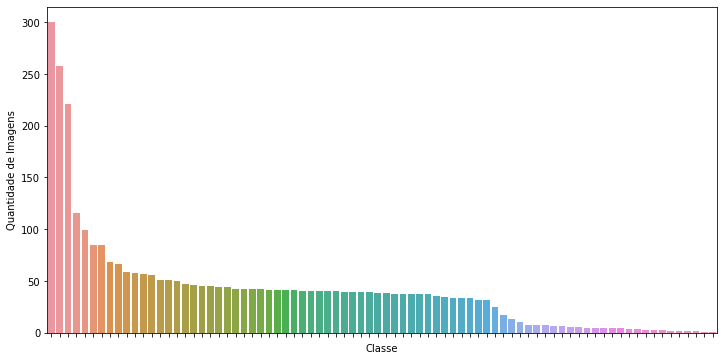

In [10]:
s_labels = pd.Series(labels)
labels_df = s_labels.value_counts().rename_axis('Classe').reset_index(name='Quantidade de Imagens')
# Define image size
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x="Classe", y="Quantidade de Imagens", data=labels_df)
ax.set(xticklabels=[])
plt.savefig('Distribution_1.eps', format='eps')

### Showing some images

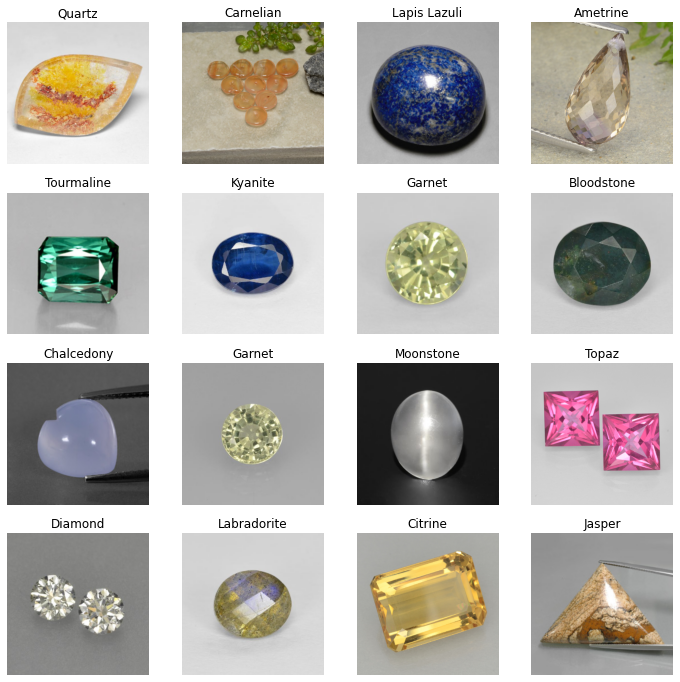

In [11]:
dim = 4
f, ax = plt.subplots(dim, dim, figsize=(12, 12)) 
for i in range(0, dim):
    for j in range(0, dim):
        rnd_number = randint(0, len(images) - 1)
        cl = labels[rnd_number]
        ax[i,j].imshow(images[rnd_number])
        ax[i,j].set_title(cl)
        ax[i,j].axis('off')
fig.tight_layout()

plt.savefig('Gemstones.eps', format='eps')

### Data Augmentation

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.5),
  layers.RandomZoom(.2, .2),
])

new_images = []
new_labels = []

for item in labels_df.itertuples():
    gemstone_class = item[1]
    images_by_class = item[2]

    for i in range(min_img_per_class - images_by_class):
        index_image = random.choice(s_labels.loc[s_labels == gemstone_class].index)
        new_image = data_augmentation(images[index_image])

        new_images.append(new_image)
        new_labels.append(gemstone_class)

### Show augmented images 

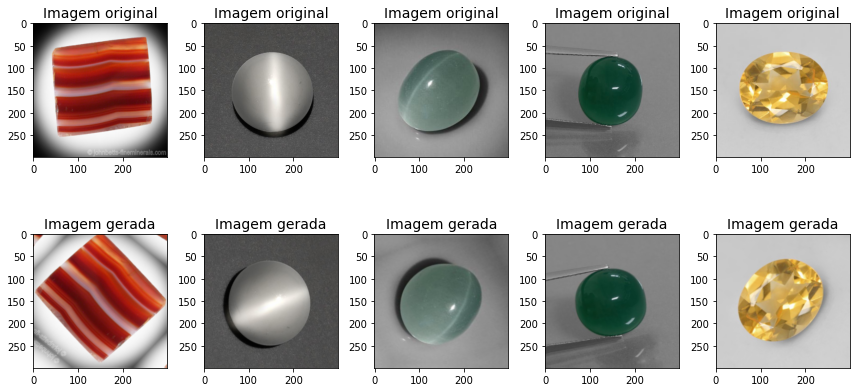

In [13]:
ncols = 5
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(12, 6))

for i in range(ncols):
    index = random.randint(0, len(images) - 1)
    ax[0][i].imshow(images[index])
    ax[0][i].set_title('Imagem original', fontsize=14)
    ax[1][i].imshow(data_augmentation(images[index]) / 255)
    ax[1][i].set_title("Imagem gerada", fontsize = 14)

fig.tight_layout()

plt.savefig('DataAugmentation.eps', format='eps')

### Saving augmented images

In [14]:
for i, image_label in enumerate(zip(new_images, new_labels)):
    tf.keras.preprocessing.image.save_img('/content/images/%s/aug_%s.png' % (image_label[1], i), image_label[0])

### New distribution of images

80 gemstone with 4880 images


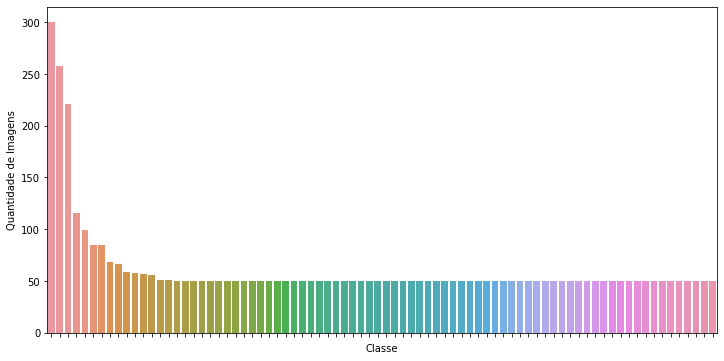

In [15]:
images, labels = load_images(image_path)
print("{0} gemstone with {1} images".format(len(np.unique(labels)), len(images)))

s_labels = pd.Series(labels)
labels_df = s_labels.value_counts().rename_axis('Classe').reset_index(name='Quantidade de Imagens')
# Define image size
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x="Classe", y="Quantidade de Imagens", data=labels_df)
ax.set(xticklabels=[])  

plt.savefig('Distribution_2.eps', format='eps')

### Undersampling

In [16]:
%%bash

for dir in /content/images/*/
do   
    find "${dir}" -type f -print0 | sort -zR | tail -zn +51 | xargs -0 rm -f
done

### Final distribution

80 gemstone with 4000 images


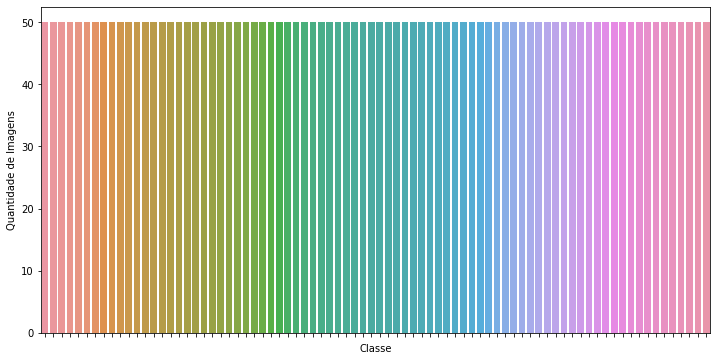

In [17]:
images, labels = load_images(image_path)
print("{0} gemstone with {1} images".format(len(np.unique(labels)), len(images)))

s_labels = pd.Series(labels)
labels_df = s_labels.value_counts().rename_axis('Classe').reset_index(name='Quantidade de Imagens')
# Define image size
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x="Classe", y="Quantidade de Imagens", data=labels_df)
ax.set(xticklabels=[])  

plt.savefig('Distribution_3.eps', format='eps')

### Total of images

In [18]:
images, labels = load_images(image_path)
print("{0} gemstone with {1} images".format(len(np.unique(labels)), len(images)))

80 gemstone with 4000 images


### Splitting images in train, validation and test

In [116]:
! splitfolders --ratio .8 .1 .1 -- images

Copying files: 4000 files [00:00, 4590.21 files/s]


### Saving files to S3

In [117]:
s3_client = boto3.client(
    's3',
    aws_access_key_id = config["S3"]["AWS_ACCESS_KEY_ID"],
    aws_secret_access_key = config["S3"]["AWS_SECRET_ACCESS_KEY"]
)

for root, dirs, files in os.walk("output"):

  for filename in files:

    local_path = os.path.join(root, filename)

    s3_client.upload_file(local_path, 
                      config["S3"]["BUCKET"], 
                      local_path)
